# Traffic Sign Detection

<br/><br/><br/>
<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/2/2d/Intersection_over_Union_-_object_detection_bounding_boxes.jpg" alt="Source: Wikipedia commons" width="500" >
<p><small>Source: Wikipedia commons</small></p></center>

<p>So far, most of our examples were focused on solving the task of object recognition where we associate each image in a dataset to a single class $c$ from a pre-defined set of classes $C$.</p> 

Closely related to this is the problem of object detection, where each image may contain multiple objects of interest at different places. It is now our job to both localise and classify such objects.

Clearly one problem *contains* the other and it is natural to think that solving one (classification) could help solve the other. Instead, what is a bit less obvious is whether an object detection network that has been trained to detect objects from a class $C$ can be slightly modified to detect objects from class $D$. 

In this project you will learn how to modify a pre-trained network to work on a different set of classes in a process called **Transfer Learning**.  

We will first look into how these tasks are related and how we can expand from one to another. This will be done by first defining some relevant metrics to measure the quality of our predictions.

We will then adapt and fine-tune an object detection network that has been trained on COCO Dataset to work with the German Traffic Sign Detection Benchmark dataset.





## Object Detection Metrics

When trying to solve a problem, the first thing we should do is to decide on a measure of quality for a solution. In the case of image classification, this was accomplished by using *classification accuracy*.

In the case of object detection we also need to know where objects are in the image. In practice, which means that our network must now provide corners of a bounding box $\left(x_0,y_0,x_1,y_1\right)$ along with a class $c$ for each detected object. These bounding-boxes and their associated classes will then be compared to the ground-truth set of bounding-boxes and classes. As we will see, this comparison is not straight-forward. 

Let's consider the following scenario where you want to retrieve all instances of a cat in the image below.

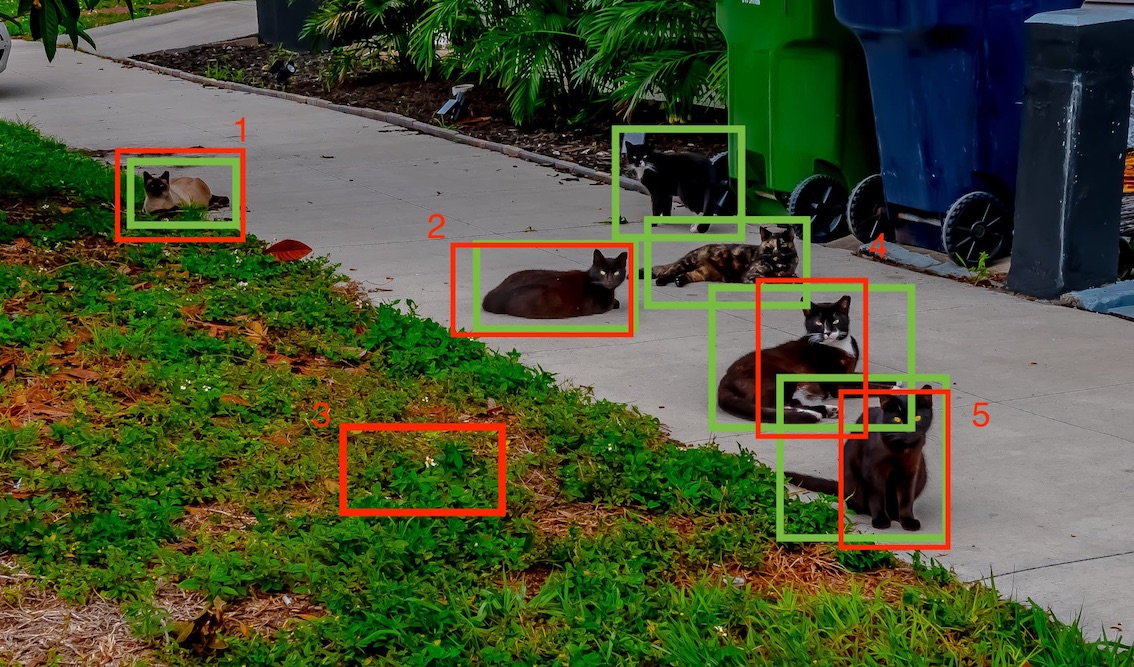

The green bounding-boxes serve as ground-truth, while the red bounding boxes are the ones generated by the network.  

### Precision and Recall

As you can see, bounding-box 1,2,4,5 have correctly detected four out of six cats. These are the so called **True Positives**.
The network missed two cats, which are the **False Negatives** and wrongfully classified a patch of grass as cat, a **False Positive**.

Given these definitions, let's introduce the following concepts:


> __*Precision*__: Measures the percentage of correct predictions. 
>>$\frac{TP}{TP+FP}$ 

> __*Recall*__: Measures how well you can retrieve all instance of that class
>>$\frac{TP}{TP+FN}$


It should be clear from these definitions that both precision and recall depend on the number of bounding-boxes (True of False Positives) being output by the network. What happens to precision if the network always outputs a large number of bounding-boxes and there are only a few objects in the scene? 

We solve this problem by having a network that will generate a fixed, albeit large, number of bounding-boxes and a scalar measure of *objectness* for each box. This will measure how likely it is that that each bounding-box will contain an actual object and not just background. 

The *objectness* can be used to rank bounding-boxes, as indicated in the previous image, and the number of *True Positives* and *False Positives* will then be limited by a chosen threshold on *objectness*. 

It now makes sense to define Precision and Recall according to how bounding-boxes were sorted.  


Order | Type | Precision | Recall
--- | --- | --- | --- 
1 | TP | 1.00 = 1/(1+0) | 0.16 = 1/(1+5)
2 | TP | 1.00 = 2/(2+0) | 0.33 = 2/(2+4)
3 | FP | 0.67 = 2/(2+1) | 0.33 = 2/(2+4)
4 | TP | 0.75 = 3/(3+1) | 0.50 = 3/(3+3)
5 | TP | 0.80 = 4/(4+1) | 0.66 = 4/(4+2)

### Mean Average Precision (mAP)

When calculating Precision and Recall considering all instances of a particular class $c$, the previous table can be better represented by the curve seen below.

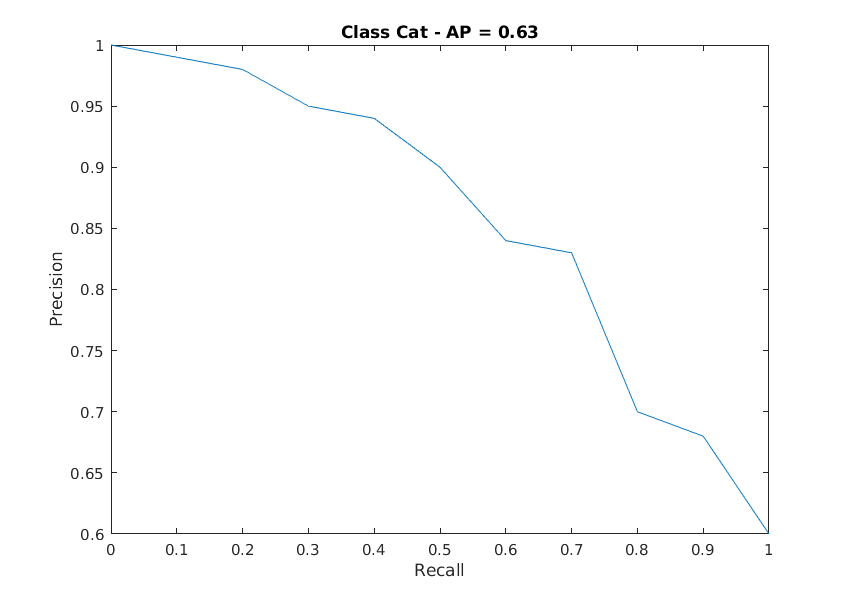

Every point in the curve represents a choice of threshold and hence a row in the previous table. 

Ideally, we would like for all classifications to be correct, so Precision would always be equal to $1$ (one) as Recall would progressively reach $1$ (classifying everyone as cats). 

In practice, lower thresholds will increase the number of *False Positives*, which in turn will lower the algorithm's precision. The threshold of choice will then depend on the application.

Given such dependency, it is better to measure the detection performance using an **Average Precision(AP)**, which is the *area below the  Precision-Recall curve*. 

If we repeat this process for all classes in $C$ and get the mean **Average Precision**, we get what is called... **Mean Average Precision (mAP)**, and that is the primary metric used in object detection.   

### Intersection over Union (IoU)

So far, we haven't talked about the *localisation quality* of our network. How do we decide if a bounding-box is good enough? 

Ideally, we would like our generated bounding-boxes to perfectly overlap the ground-truths', i.e. a large intersection with small non-intersecting areas. 

This is were the concept of Intersection of Union comes in hand.

<center>
$IoU = \frac{intersection}{union}$
</center>
<p></p>

<center><img src="https://upload.wikimedia.org/wikipedia/commons/e/e6/Intersection_over_Union_-_poor%2C_good_and_excellent_score.png" ></center>
<center><small><p>Source: Wikipedia Intersection over Union</p></small></center>

As seen in the the image above, IoU varies from 0 to 1, where lower values of IoU translate to poor localisation while higher values translate to better localisation. 


In practice, in order to take localisation into consideration during test, we may want to consider calculating mAP for different values of IoU.

# Faster-RCNN

We now look at the specific architecture for Object Detection called Faster-RCNN.

The key idea behind Faster-RCNN is to leverage an existing Object Detection Neural Network to perform both localisation and classification of objects in a scene.

<center><img src="https://miro.medium.com/max/1096/1*e6dx5qzUKWwasIVGSuCyDA.png" alt="Source: Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks" width="500px"></center>
<center><p><small>Source: Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks</small></p></center>

The Network is essentially made of three sub-networks:
1. A backbone object classification network that will produce feature maps.
2. A **Region Proposal Network (RPN)** which will generate bounding-boxes each of which having an *objectness* score.
3. A Classification Layer, that will warp the regions proposed by the RPN and classify them according to our set of classes. 


Faster-RCNN is a fairly complex network and training it from scratch on our specific dataset would probably not be a good idea. 

As a matter of fact, it would be *inadvisable* to do so as our Traffic Sign Dataset contains (relatively) little data and probably not be enough to train the backbone part of our network. 

A better idea would be to start with a pre-trained backbone network and just retrain the classifier.   




## Transfer Learning with Faster-RCNN

We will first need to download some helper functions that perform the metrics discussed above. These are provided by the Torch Vision repository, which is the same repository that will provide us with Faster-RCNN pre-trained on the COCO dataset. 

You are welcome to look into those to get a better understanding of what they do.   

### Download Original Dataset

It is important to understand how our new dataset (GTSDB) is organized. This will allow us to adapt our dataset to our pre-trained network's needs.

The following piece of code will download and extract the dataset inside your Google Drive. 

Navigate to your new *FullIJCNN2013* folder and take a look at the **ReadMe.txt** file. More specifically, make sure you understand the description in Item 3. 

In [ ]:
# Download German Traffic Sign Detection Benchmark (GTSDB)
!test -f './datasets/FullIJCNN2013.zip'
!test -f './datasets/FullIJCNN2013.zip' || wget https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip -nv -P './datasets/'
!test -d './datasets/FullIJCNN2013' ||  unzip -q './datasets/FullIJCNN2013.zip' -d './datasets/'
print("Done Extracting GTSDB")

### Create PyTorch Dataset

We must now create a PyTorch Dataset which will provide the network data the expected format.

Visit the Torch Vision API page (https://pytorch.org/docs/stable/torchvision/models.html#faster-r-cnn).
What kind of inputs is Faster-RCNN expecting during training? 



***Ans:***
1. Images in the form of Tensors.
2. A list of dictionaries containing *boxes* (FloatTensor[N, 4]) as [x1, y1, x2, y2] and *labels* (Int64Tensor[N]) for each box



Now complete the following PyTorch Dataset Class to reflect how data should be loaded. Make sure you understand what each line is doing.

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from PIL import ImageDraw

class GTSDBDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None, train=True):
        self.root = root
        self.transforms = transforms

        self.csv_file = os.path.join(self.root, 'gt.txt')       
        image_set = set()
        with open(self.csv_file, 'r') as f:
          for line in f:
            img_name,_,_,_,_,_ = tuple(line.split(';'))
            image_set.add(img_name)
        
        self.all_boxes =   [[]  for _ in range(len(image_set)) ]
        self.all_labels = [[] for _ in range(len(image_set)) ]
        self.all_images = [None] * len(image_set)

        with open(self.csv_file, 'r') as f:
          last_idx, counter = 0, 0
          for line in f:
            img_name, x_min, y_min, x_max, y_max, class_id = tuple(line.split(';'))
            x_min, y_min = int(x_min), int(y_min)
            x_max, y_max = int(x_max), int(y_max)
            img_idx = int(img_name[:5])
            if img_idx != last_idx:
              counter += 1
            self.all_boxes[counter].append([x_min, y_min, x_max, y_max]) 
            self.all_labels[counter].append(int(class_id))
            self.all_images[counter] = img_idx
            last_idx = img_idx

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "{:05d}.ppm".format( self.all_images[idx] ))
        img = Image.open(img_path).convert("RGB")

        #############################
        ## Complete below
        ## look for torch.as_tensor
        #############################
        boxes = None
        labels = None
        #############################
        image_id = torch.tensor([idx])
        
        
        # suppose all instances are not crowd
        num_objs = len(boxes)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.all_images)

#### Defining transformations
As we've seen in previous examples, it is good practice to use some data augmentation transforms to help the network generalise better in different datasets.

**Complete the following code** with possible data-augmentation transforms. 

Would random crop make sense in this scenario? 
What about Horizontal Flip?

In [ ]:
!git clone https://github.com/mackopes/DNN_Practicals_Extras.git extras

In [ ]:
from extras.p11.engine import train_one_epoch, evaluate
import extras.p11.utils as utils
import extras.p11.transforms as T
import extras.p11.coco_utils as coco_utils
import extras.p11.coco_eval as coco_eval

def get_transform(train):
    transforms = []
    ## Complete here
    # Convert PIL image, into a PyTorch Tensor
    
    if train:
        ## Complete here
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        
        # Look also for torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
        pass
    return T.Compose(transforms)

### Load the created dataset

In [ ]:
# use our dataset and defined transformations
dataset = GTSDBDataset('./datasets/FullIJCNN2013', get_transform(train=True))
dataset_test = GTSDBDataset('./datasets/FullIJCNN2013', get_transform(train=False))

#### Split Dataset into Train and Test


In [ ]:
# split the dataset in train and test set.
torch.manual_seed(1) # Just to ensure that results are consistent across different runs.
num_test_instances = 10 # Number of images we want to use for test. 

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-num_test_instances])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-num_test_instances:])
collate_fn = utils.collate_fn

# Complete here with data
# define training, validation and test sets  
data_loader = None

data_loader_test = None

## Training 

Using pre-trained models is really useful as it saves us a lot of training time. Unfortunately this comes at the cost of having to find out how the model was implemented so that we can modify it. This can be tricky sometimes since we were not the ones who coded it. 

Fortunately enough, we can *print* the network and inspect it for the layers we  want to modify.

Look again at the API (https://pytorch.org/docs/stable/torchvision/models.html#faster-r-cnn) and load and print the pre-trained model.

**Complete your code here.**


In [ ]:
import torch 
import torchvision

# First load a pre-trained network
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True,)

print(model)

We now need to replace the network classifier with a new one. Fortunately enough, the design of Faster RCNN is modular, so we can replace the **FastRCNNPredictor** (responsible for generating the output of our network) with one that will fit the new number of classes.  

Our original network was pre-trained on the COCO dataset, which contained 91 classes. Our new dataset will now contain 43 classes. The number of bounding boxes that the network will output should not change. 

Look at the network description above and replace the **roi_heads.box_predictor** block with a new one using the **FasteRCNNPredictor(in_features, num_classes)** function. 

Notice that will first need to retrieve the original number of feature entering that block. 

Print the network description again and verify that it has changed. 

**You will need to complete code here.**

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

############################################################################
# Define new number of classes
num_classes = None

# Complete here
# get number of input features for the classifier
in_features = None

# Complete here
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = None

############################################################################
print(model)


### Perform Training


Hint: see the [COCO evaluation docs](https://cocodataset.org/#detection-eval) to interpret the metrics in the end.

In [ ]:
# let's train it for 10 epochs
num_epochs = 10

# Use GPU ('cuda') when possible
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

### Results


In [ ]:
# Read class labels
labels_signs = ['20','30','50','60','70','80','restriction ends 80','100','120',
                'no overtaking','no overtaking (tr)','priority at next int',
                'priority road','give way','stop','no traffic both ways',
                'no trucks','no entry','danger','bend left','bend right','bend',
                'uneven road','slippery road','road narrows','construction',
                'traffic signal','pedestrian crossing','school crossing',
                'cycles crossing','snow','animals','restriction ends','go right',
                'go left','go straight','go right or straight',
                'go left or straight','keep right','keep left','roundabout',
                'restriction ends (overt)','restriction ends (overt tr)']


## Visualize some examples 
Select a value for **random_idx** and **threshold** to see your detection results

In [ ]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms

# Complete here
# Select one image from the test set from [0,num_test_instances]
random_idx = 2
threshold  = 0.5


def plot_detections(random_idx, threshold):
  img, target = dataset_test[random_idx]
  img1 = transforms.ToPILImage()(img).convert("RGB")

  # put the model in evaluation mode
  model.eval()
  with torch.no_grad():
    prediction = model([img.to(device)])
  
  plt.figure()
  fig, ax = plt.subplots(1, figsize=(12,9))
  ax.imshow(img1)
  cmap = plt.get_cmap('tab20b')
  colors = [cmap(i) for i in np.linspace(0, 1, 20)]
  print("Number of signs detected: " + str(len(prediction[0]['boxes'])) )

  for k in range( len(prediction[0]['boxes'])):
    if prediction[0]['scores'][k].item() > threshold:
      x_min, y_min, x_max, y_max =prediction[0]['boxes'][k]
      x_min, x_max = x_min.cpu().numpy(), x_max.cpu().numpy()
      y_min, y_max  = y_min.cpu().numpy(), y_max.cpu().numpy()
      bbox = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min,
             linewidth=2, edgecolor="red", facecolor='none')
      ax.add_patch(bbox)
      text = labels_signs[ prediction[0]['labels'][k] ] + ": " + str(prediction[0]['scores'][k].item())[0:4]
      plt.text(x_min, y_min,text, fontdict=dict(color='red', fontsize=13))
  
  plt.axis('off')

plot_detections(random_idx, threshold)



In [ ]:
savefolder = './results/p11'
savepath = './results/p11/traffic_sign.pth'
if not os.path.exists(savefolder):
    os.makedirs(savefolder)
torch.save(model.state_dict(), savepath)

# Bonus

1.   Create your own functions to calculate mAP for the new network. Remember that it should be a function of IoU. 

2.   Very small traffic signs can sometimes be a problem for neural networks. Try to upsample the images inside your dataset and see if you get better results.


